In [1]:
import numpy as np
import h5py
import os
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
resultsdir = '../results/cartpole_ddpg4'

In [4]:
savedirs = {
    'normal': 'normal_buffer',
    'prioritized': 'prioritized_buffer',
    
    'normal_large': 'normal_buffer_large',
    'prioritized_large': 'prioritized_buffer_large'
}
for k in savedirs:
    savedirs[k] = os.path.join(resultsdir,savedirs[k])

In [5]:
def loadHDF5(filepath):
    output = {}
    with h5py.File(filepath,'r') as f:
        for k in f:
            output[k] = np.array(f[k])
    return output

In [6]:
results = {}
for sd in savedirs:
    results[sd] = {}
    data = []
    for rd in os.listdir(savedirs[sd]):
        filepath = os.path.join(savedirs[sd],rd,'log.h5')
        
        if os.path.exists(filepath):
            data.append(loadHDF5(filepath))
            
        if len(data) > 0:
            keys = data[0].keys()
            for k in keys:
                try:
                    results[sd][k] = np.stack([v[k] for v in data])
                except:
                    pass

In [7]:
for k in sorted(results['prioritized'].keys()):
    print(k)

action_history
beta
duration_cumulative
priorities
reward_history
sample_importance_weights
step_duration_sec
td_error
test_ep_returns
test_ep_steps


In [8]:
results[sd]['test_ep_returns'].shape

(10, 199)

In [47]:
def plot_percentiles(x,y=None,label=None):
    if y is None:
        y = x
        x = np.arange(len(y))
    p10 = np.percentile(y,1,axis=1)
    mean = y.mean(axis=1)
    p90 = np.percentile(y,99,axis=1)
    plt.fill_between(x,p10,p90,alpha=0.25)
    plt.plot(x,mean,label=label)

In [48]:
results[sd]['test_ep_steps'].shape

(10, 199)

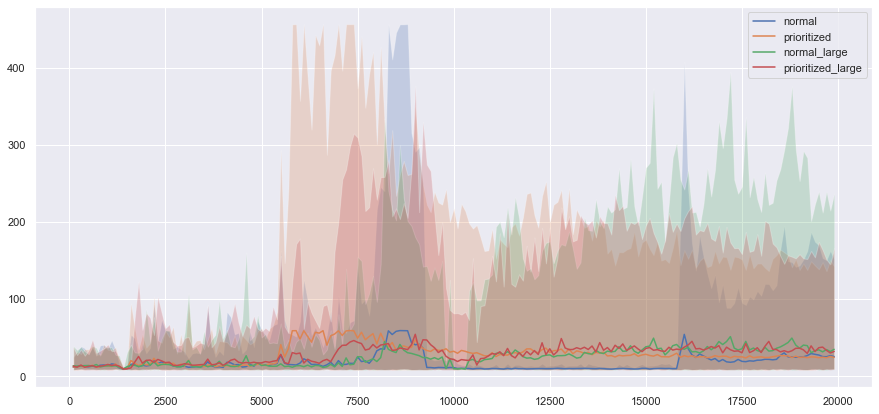

In [49]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

In [60]:
results[sd][key].shape

(10, 20000)

In [63]:
help(np.convolve)

Help on function convolve in module numpy:

convolve(a, v, mode='full')
    Returns the discrete, linear convolution of two one-dimensional sequences.
    
    The convolution operator is often seen in signal processing, where it
    models the effect of a linear time-invariant system on a signal [1]_.  In
    probability theory, the sum of two independent random variables is
    distributed according to the convolution of their individual
    distributions.
    
    If `v` is longer than `a`, the arrays are swapped before computation.
    
    Parameters
    ----------
    a : (N,) array_like
        First one-dimensional input array.
    v : (M,) array_like
        Second one-dimensional input array.
    mode : {'full', 'valid', 'same'}, optional
        'full':
          By default, mode is 'full'.  This returns the convolution
          at each point of overlap, with an output shape of (N+M-1,). At
          the end-points of the convolution, the signals do not overlap
          co

In [67]:
np.cumsum(results[sd][key].T,axis=0).shape

(20000, 10)

In [76]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

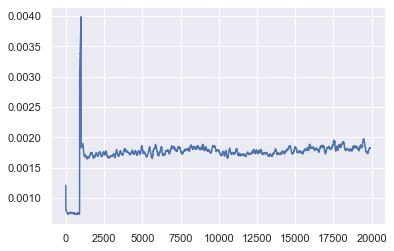

In [78]:
plt.plot(moving_average(results[sd][key].T).mean(axis=1))

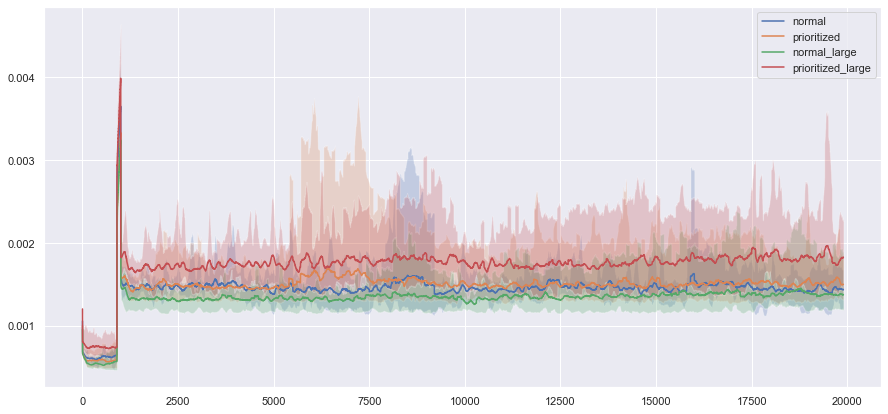

In [82]:
key = 'step_duration_sec'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(moving_average(results[sd][key].T),label=sd)
_ = plt.legend()
#plt.ylim(0,0.004)

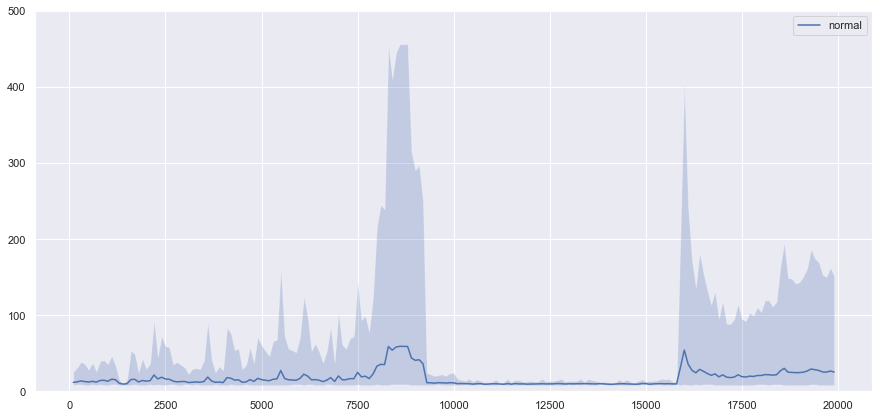

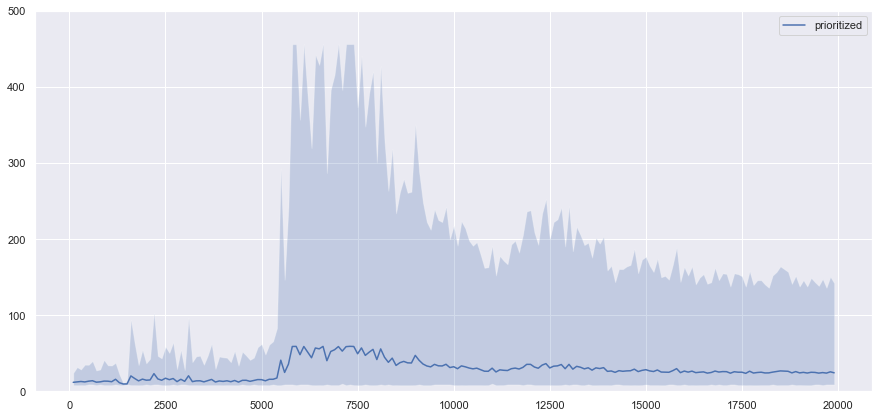

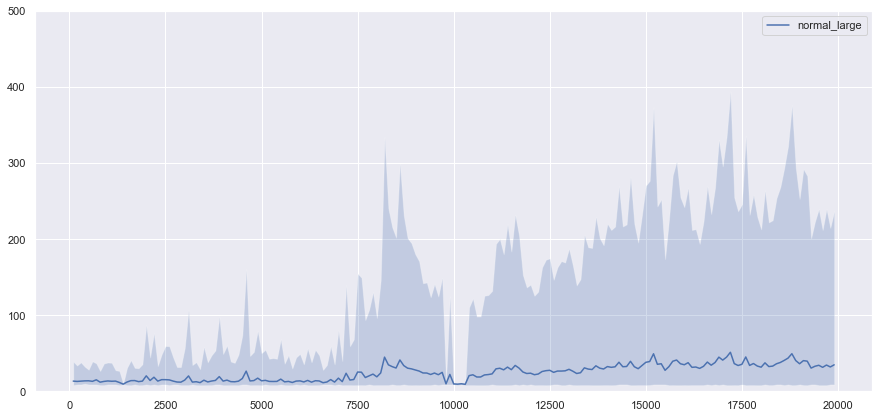

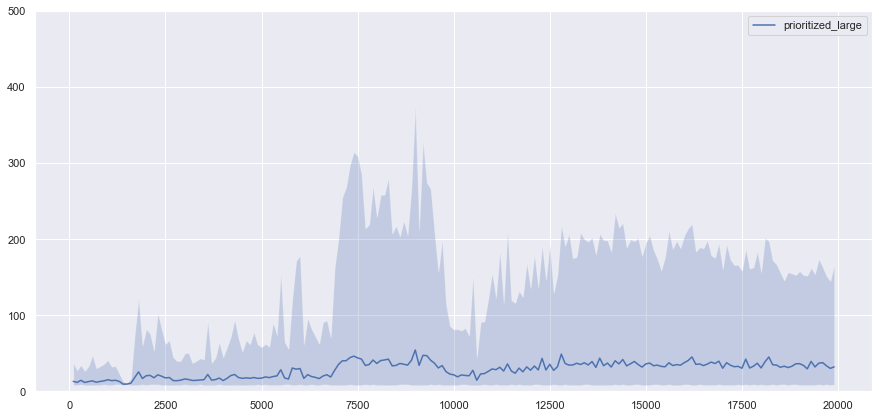

In [51]:
key = 'test_ep_returns'
for sd in results:
    plt.figure(figsize=(15,7))
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
    _ = plt.legend()
    plt.ylim(0,500)
    plt.show()

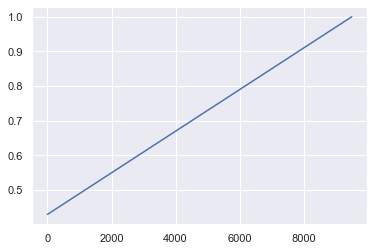

In [43]:
plt.plot(results['prioritized']['beta'][0])

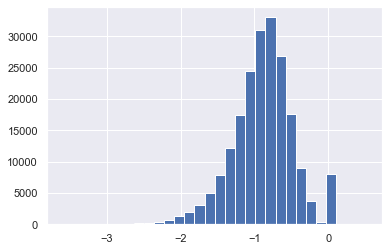

In [12]:
_ = plt.hist(np.log10(results['prioritized']['priorities'].ravel()),bins=30)

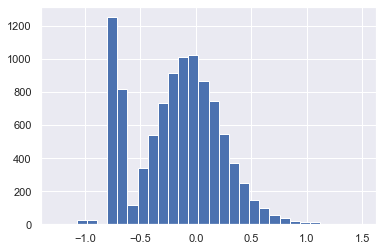

In [13]:
_ = plt.hist(np.log10(results['prioritized']['sample_importance_weights'].ravel()),bins=30)

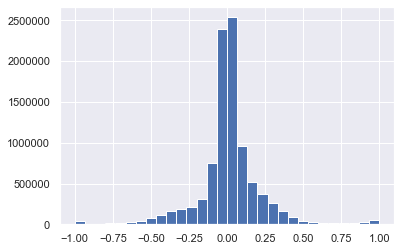

In [37]:
_ = plt.hist(np.clip(results['prioritized']['td_error'].ravel(),-1,1),bins=30)

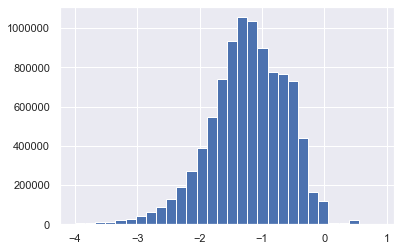

In [39]:
_ = plt.hist(np.log10(np.abs(results['prioritized']['td_error'].ravel())+1e-4),bins=30)